# Import relevant libraries

In [1]:
import os
import math
import copy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
# disable false positive warnings
pd.options.mode.chained_assignment = None

# Setup path

In [3]:
# set up paths
base_path = '../datasets'
cleaned_data_path = os.path.join(base_path, 'cleaned_data')

# Load data

In [4]:
node_edge_df = pd.read_csv(os.path.join(cleaned_data_path, 'node_edge_data.csv'))
perf_eval_df = pd.read_csv(os.path.join(cleaned_data_path, 'perf_eval_table.csv'))

In [5]:
print(f'number of observation: {len(perf_eval_df)}')
perf_eval_df.head()

number of observation: 26594


,club_name,player_name,age,position,club_involved_name,transfer_movement,fee_cleaned,year
0,Ajax Amsterdam,Marc Overmars,19.0,Left Winger,Willem II,in,0.817,1992
1,Ajax Amsterdam,Jari Litmanen,21.0,Attacking Midfield,MYPA,in,0.013,1992
2,Ajax Amsterdam,Aron Winter,25.0,Defensive Midfield,Lazio,out,1.170,1992
3,Sparta Rotterdam,Winston Bogarde,21.0,Centre-Back,Excelsior,in,0.005,1992
4,Willem II Tilburg,Marc Overmars,19.0,Left Winger,Ajax,out,0.817,1992


# Analysis

**Thesis Statement:**

Workflow:
1) Step1  
2) Step2  
3) Step3  

**To do**
- There seems to be a trend on age-price so we dev scaling factor (average price by age with base age) to diminish the effect of age on price.
- Identify the effect of homophily (Membership closure) on performance -> performance metric = f(price, scaling_factor) and maybe with combination of other metrics
- Identify the behavior of the transfer if it's related to our analysis,   
  - if yes: the analysis might be the cause  
  - if no: give some recommendation

## Fee-Age Analysis

In [6]:
fee_age = perf_eval_df[['age', 'fee_cleaned']]
fee_age

,age,fee_cleaned
0,19.0,0.817
1,21.0,0.013
2,25.0,1.170
3,21.0,0.005
4,19.0,0.817
...,...,...
26589,25.0,2.250
26590,23.0,4.500
26591,23.0,0.450
26592,28.0,2.480


<AxesSubplot:xlabel='age', ylabel='fee_cleaned'>

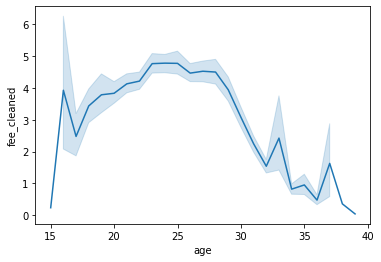

In [7]:
# the variance is quite high
sns.lineplot(data = fee_age, x = 'age', y = 'fee_cleaned', estimator= np.mean, ci = 95)

<AxesSubplot:xlabel='fee_cleaned', ylabel='Count'>

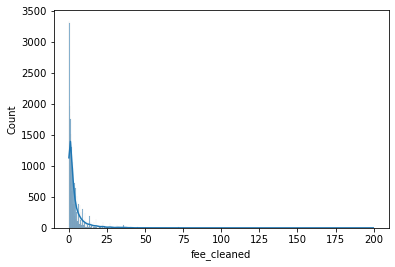

In [8]:
# heavy-tailed distribution --> median would be a more sensible mid-point measure
# as mean would be influenced by the outliers
sns.histplot(fee_age['fee_cleaned'], kde = True)

In [9]:
# descriptive statistics
desc_stat = fee_age.groupby('age')['fee_cleaned']\
                   .agg(['mean', 'median', 'std', 'min', 'max', 'count'])
# remove group with small number of observations
desc_stat = desc_stat[desc_stat['count'] > 100]

In [10]:
# There are some outliers that greatly influence the mean and thus using median is more robust
desc_stat

,mean,median,std,min,max,count
age,,,,,,
17.0,2.476510,0.990,3.844370,0.005,21.60,145
18.0,3.433969,1.350,6.202667,0.002,40.50,512
19.0,3.783434,1.350,9.608391,0.005,130.50,1052
20.0,3.830943,1.580,7.183568,0.009,124.20,1605
21.0,4.126564,1.530,7.276784,0.005,79.38,2169
22.0,4.212821,1.620,6.906991,0.004,67.50,2549
23.0,4.760516,1.980,8.301757,0.009,94.50,2802
24.0,4.775991,1.980,8.126826,0.008,90.90,2771
25.0,4.769627,2.120,9.505160,0.009,199.80,2594


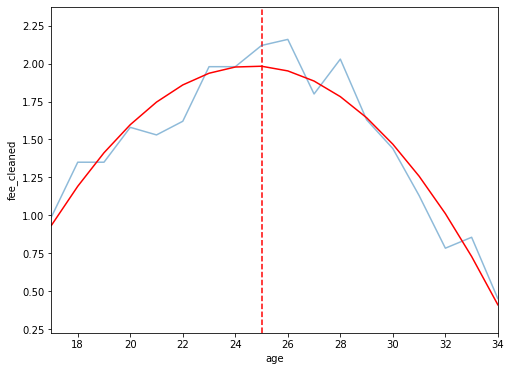

In [11]:
# visualize
fig, ax = plt.subplots(figsize = (8, 6))

sns.lineplot(data = fee_age, x = 'age', y = 'fee_cleaned', estimator= np.median, ci = None, alpha = 0.5)

xlim = (desc_stat.index[0], desc_stat.index[-1])
ylim = (min(desc_stat['median']*0.5), max(desc_stat['median'])*1.1)

# fit polynomial to smoothen the trend (for adjustment coefficient)
x = list(desc_stat['median'].index)
y = list(desc_stat['median'])

# smoothen the liner
fit = np.polyfit(x, y, deg = 2)
poly1d = np.poly1d(fit)

# add adjustment line
plt.plot(x, poly1d(x), '-', c = 'red')

# get the turning point (slope < 0)
idx = [idx for idx,val in enumerate(np.diff(poly1d(x))) if val < 0][0]

# add vertical line at the turning point
plt.vlines(x = x[idx], ymin = ylim[0], ymax = ylim[1],
           colors = 'red', linestyles = 'dashed')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.show()

In [12]:
# develop adjustment coefficient
fitted_value = poly1d(x)

baseline = fitted_value[0]
base_value = np.divide(fitted_value, baseline)
coef = np.reciprocal(base_value)

temp_df = pd.DataFrame(data = {'age': desc_stat['median'].index, 
                               'coef': coef})
temp_df

,age,coef
0,17.0,1.000000
1,18.0,0.784209
2,19.0,0.661457
3,20.0,0.584819
4,21.0,0.534897
5,22.0,0.502366
6,23.0,0.482366
7,24.0,0.472339
8,25.0,0.471119
9,26.0,0.478570


In [13]:
# extend age range to cover the data using lower-upper bound coefficient
age_df = pd.DataFrame(data = {'age': sorted(fee_age['age'].unique())})
adj_coef_table = pd.merge(age_df, temp_df, on = 'age', how = 'left')
adj_coef_table['coef'] = adj_coef_table['coef'].interpolate(method = 'linear', limit_direction = 'both')
adj_coef_table

,age,coef
0,15.0,1.000000
1,16.0,1.000000
2,17.0,1.000000
3,18.0,0.784209
4,19.0,0.661457
5,20.0,0.584819
6,21.0,0.534897
7,22.0,0.502366
8,23.0,0.482366
9,24.0,0.472339


## Homophily-Performance Analysis

In [14]:
print(f'number of observation: {len(node_edge_df)}')
node_edge_df.head()

number of observation: 163001


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year
0,Fortuna Sittard,Rene Hofman,31.0,Right Winger,Roda JC,?,in,NaN,1992
1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,NaN,1992
2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,NaN,1992
3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,0.0,1992
4,Fortuna Sittard,Jerry Taihuttu,22.0,Centre-Forward,Helmond Sport,Loan,out,0.0,1992


### Create structured data

In [15]:
# 2 components needed: 'year_list', 'club_list'
year_list = sorted(sorted(node_edge_df['year'].unique()))
club_list = sorted(node_edge_df['club_name'].unique())

In [16]:
# define function to remove elements in a list from another list
def remove_elem_by_list(list1, list2):
    for elem in list2:
        try:
            list1.remove(elem)
        except Exception:
            pass
    return list1

In [17]:
# nested dictionary: year: `club_member`
nested_dict = {}
prev_year = None

# loop over year:
for year in tqdm(year_list):
    
    if prev_year in nested_dict.keys():
        
        # retrieve club-player info in the previous year for the second year and so on
        club_member = copy.deepcopy(nested_dict[prev_year])
    
    else:
        # initiate a dictionary of clubs (keys) and their affiliated players (values)
        club_member = {}
    
    # subset data by year
    data = node_edge_df[node_edge_df['year'] == year]
    
    # subset for transfer_movement == 'in', 'out' 
    data_in = data[data['transfer_movement'] == 'in']
    data_out = data[data['transfer_movement'] == 'out']
        
    # loop over club:
    for club in club_list:
        
        # subset data by club 
        temp_data_in = data_in[data_in['club_name'] == club]
        temp_data_out = data_out[data_out['club_name'] == club]
        
        # update all players in that club in the dictionary (`club_member`)
        player_list_in = list(temp_data_in['player_name'])
        player_list_out = list(temp_data_out['player_name'])
        
        if prev_year in nested_dict.keys():
            
            # catch bug (The case when club has no member yet)
            if club_member[club] is None:
                club_member[club] = []
            
            # adjust for members who move in
            club_member[club].extend(player_list_in)
            # adjust for members who move out
            remove_elem_by_list(club_member[club], player_list_out)
            
        else:
            # update club_member info
            club_member[club] = remove_elem_by_list(player_list_in, player_list_out)
            
    # store `club_member` in `nested_dict`
    nested_dict[year] = club_member
    
    # set previous year
    prev_year = year

### Performance Analysis (Fee)

In [18]:
perf_eval_df.head()

,club_name,player_name,age,position,club_involved_name,transfer_movement,fee_cleaned,year
0,Ajax Amsterdam,Marc Overmars,19.0,Left Winger,Willem II,in,0.817,1992
1,Ajax Amsterdam,Jari Litmanen,21.0,Attacking Midfield,MYPA,in,0.013,1992
2,Ajax Amsterdam,Aron Winter,25.0,Defensive Midfield,Lazio,out,1.170,1992
3,Sparta Rotterdam,Winston Bogarde,21.0,Centre-Back,Excelsior,in,0.005,1992
4,Willem II Tilburg,Marc Overmars,19.0,Left Winger,Ajax,out,0.817,1992


In [19]:
adj_coef_table.head()

,age,coef
0,15.0,1.000000
1,16.0,1.000000
2,17.0,1.000000
3,18.0,0.784209
4,19.0,0.661457


In [20]:
# add `adjusted_fee` column which adjusted for player's age
perf_eval_df = pd.merge(perf_eval_df, adj_coef_table, on = 'age', how = 'left')
perf_eval_df['adjusted_fee'] = np.multiply(perf_eval_df['fee_cleaned'], perf_eval_df['coef'])

# remove `coef` column
perf_eval_df.drop(columns = 'coef', inplace = True)
perf_eval_df.head()

,club_name,player_name,age,position,club_involved_name,transfer_movement,fee_cleaned,year,adjusted_fee
0,Ajax Amsterdam,Marc Overmars,19.0,Left Winger,Willem II,in,0.817,1992,0.540411
1,Ajax Amsterdam,Jari Litmanen,21.0,Attacking Midfield,MYPA,in,0.013,1992,0.006954
2,Ajax Amsterdam,Aron Winter,25.0,Defensive Midfield,Lazio,out,1.170,1992,0.551210
3,Sparta Rotterdam,Winston Bogarde,21.0,Centre-Back,Excelsior,in,0.005,1992,0.002674
4,Willem II Tilburg,Marc Overmars,19.0,Left Winger,Ajax,out,0.817,1992,0.540411


In [21]:
# subset only `transfer_movement` == 'in'; we want to analyze the number of ties a player has
# before entering a team
df = perf_eval_df[perf_eval_df['transfer_movement'] == 'in']
df.reset_index(drop = True, inplace = True)
# clean the table
df.drop_duplicates(inplace = True)

In [22]:
# add column `num_transfer` which represent the number of time a player moved
df['count'] = 1
df['num_transfer'] = df.groupby('player_name')['count'].cumcount() + 1
df['max_transfer'] = df.groupby('player_name')['num_transfer'].transform(np.max)
df.drop(columns = 'count', inplace = True)
print(f'number of observation: {len(df)}')
df.head()

number of observation: 15392


,club_name,player_name,age,position,club_involved_name,transfer_movement,fee_cleaned,year,adjusted_fee,num_transfer,max_transfer
0,Ajax Amsterdam,Marc Overmars,19.0,Left Winger,Willem II,in,0.817,1992,0.540411,1,3
1,Ajax Amsterdam,Jari Litmanen,21.0,Attacking Midfield,MYPA,in,0.013,1992,0.006954,1,2
2,Sparta Rotterdam,Winston Bogarde,21.0,Centre-Back,Excelsior,in,0.005,1992,0.002674,1,3
3,PSV Eindhoven,Arthur Numan,22.0,Left-Back,Twente FC,in,1.150,1992,0.577721,1,1
4,Feyenoord Rotterdam,Michael Obiku,23.0,Centre-Forward,Anorthosis,in,0.327,1992,0.157734,1,1


In [23]:
# only select the players that have at least two transfers to see the improvement
target_player = list(df[df['num_transfer'] > 1]['player_name'])

df = df[df['player_name'].isin(target_player)]
df.reset_index(drop = True, inplace = True)
print(f'number of observation: {len(df)}')
df.head()

number of observation: 8960


,club_name,player_name,age,position,club_involved_name,transfer_movement,fee_cleaned,year,adjusted_fee,num_transfer,max_transfer
0,Ajax Amsterdam,Marc Overmars,19.0,Left Winger,Willem II,in,0.817,1992,0.540411,1,3
1,Ajax Amsterdam,Jari Litmanen,21.0,Attacking Midfield,MYPA,in,0.013,1992,0.006954,1,2
2,Sparta Rotterdam,Winston Bogarde,21.0,Centre-Back,Excelsior,in,0.005,1992,0.002674,1,3
3,Ajax Amsterdam,Ronald de Boer,22.0,Right Winger,Twente FC,in,1.230,1992,0.617910,1,2
4,Cambuur-Leeuwarden bvo,Bert Konterman,21.0,Centre-Back,FC Zwolle,in,0.122,1992,0.065257,1,2


In [24]:
# get player_list
player_list = list(df['player_name'].unique())
print(f'Number of players: {len(player_list)}')
print(f'Number of clubs: {len(df.club_name.unique())}')

Number of players: 3530
Number of clubs: 306


In [25]:
# initiate a nested dictionary ---> {`was_in` {`aff_clubs` {`year_member`} } }
was_in = {}

# loop over the dataset
for player in tqdm(player_list):
    
    # subset df by player
    temp_df = df[df['player_name'] == player]
    
    # reset_index
    temp_df.reset_index(drop = True, inplace = True)
    
    # initiate inside dictionaries
    aff_clubs = {}
    
    """
    loop over the dataset to get the year and club name 
    this represent that a player stay in a club from year A - year B 
    in this case, we can ignore the last row because no further analysis is needed
    as the next transaction has not occurred yet
    """
    
    for row in range(len(temp_df) - 1):
        
        # initiate inside dictionaries
        year_member = {}
        
        club_name = temp_df.iloc[row]['club_name']
        
        year_list = np.arange(temp_df.iloc[row]['year'], temp_df.iloc[row + 1]['year'])
        
        # get the affiliated player each year from `nested_dict`
        for year in year_list:
            
            aff_players = nested_dict[year][club_name]
            
            # add data to `year_member`
            year_member[year] = aff_players
      
        # add data to aff_club 
        
        # adjust for the case when player moves back to the club he's been before
        if club_name in aff_clubs.keys():
            
                aff_clubs[club_name].update(year_member)
            
        else:
            
            aff_clubs[club_name] = year_member
            
    # add data to was_in
    was_in[player] = aff_clubs

In [26]:
# was_in

In [27]:
# table we will use
df.sort_values(['player_name', 'num_transfer'], inplace = True)
df.reset_index(drop = True, inplace = True)
print(f'number of observation: {len(df)}')
df.head()

number of observation: 8960


,club_name,player_name,age,position,club_involved_name,transfer_movement,fee_cleaned,year,adjusted_fee,num_transfer,max_transfer
0,Leeds United,Aapo Halme,19.0,Centre-Back,HJK Helsinki,in,0.504,2017,0.333374,1,2
1,Barnsley FC,Aapo Halme,21.0,Centre-Back,Leeds,in,0.203,2019,0.108584,2,2
2,Ipswich Town,Aaron Cresswell,21.0,Left-Back,Tranmere Rovers,in,0.248,2011,0.132654,1,2
3,West Ham United,Aaron Cresswell,24.0,Left-Back,Ipswich,in,4.280,2014,2.021611,2,2
4,Aston Villa,Aaron Hughes,25.0,Centre-Back,Newcastle,in,1.350,2005,0.636011,1,2


In [28]:
# get number of years in the club
num_year_stay = []
for i in range(len(df)):
    if df['num_transfer'][i] < df['max_transfer'][i]:
        val = df['year'][i+1] - df['year'][i]
        num_year_stay.append(val)
    else:
        val = max(df['year']) - df['year'][i]
        num_year_stay.append(val)
df['num_year_stay'] = num_year_stay
df.head()

,club_name,player_name,age,position,club_involved_name,transfer_movement,fee_cleaned,year,adjusted_fee,num_transfer,max_transfer,num_year_stay
0,Leeds United,Aapo Halme,19.0,Centre-Back,HJK Helsinki,in,0.504,2017,0.333374,1,2,2
1,Barnsley FC,Aapo Halme,21.0,Centre-Back,Leeds,in,0.203,2019,0.108584,2,2,1
2,Ipswich Town,Aaron Cresswell,21.0,Left-Back,Tranmere Rovers,in,0.248,2011,0.132654,1,2,3
3,West Ham United,Aaron Cresswell,24.0,Left-Back,Ipswich,in,4.280,2014,2.021611,2,2,6
4,Aston Villa,Aaron Hughes,25.0,Centre-Back,Newcastle,in,1.350,2005,0.636011,1,2,2


In [29]:
# generate `k` column

# initiate a list
k = []

# loop over the dataset
for i in tqdm(range(len(df))):
    
    # there is nothing to do with the `k` for the first transfer
    if df['num_transfer'][i] == 1:  
        
        k.append(None)
        
    else:  
        # get necessary variables (keys)
        player = df['player_name'][i]
        prev_club = df['club_name'][i-1]
        club = df['club_name'][i]
        prev_year = df['year'][i-1]
        this_year = df['year'][i]
        year_range = np.arange(prev_year, this_year)
        
        # get all the affiliated players
        aff_players = []
        for year in year_range:
            aff_player = was_in[player][prev_club][year]
            aff_players.extend(aff_player)
        
        # get all member in the club player is joining
        in_club_player = nested_dict[this_year][club]
        
        if df['num_transfer'][i] > 2:
            # accumulate affiliated players
            aff_players = set.union(set(prev_set), set(aff_players))
        
        # get `k_val`
        k_val = len(set.intersection(set(aff_players), set(in_club_player)))
        
        # append `k_val` to `k`
        k.append(k_val)
        
        # previous affiliated player set
        prev_set = set(aff_players)

# add `k` column
df['k'] = k

In [30]:
# change in fee as a proxy of performance --> `perf_change`
df['perf_change'] = df.groupby('player_name')['fee_cleaned'].pct_change()

In [31]:
# change in adjusted fee as a proxy of performance --> `perf_change_adjusted`
df['perf_change_adjusted'] = df.groupby('player_name')['adjusted_fee'].pct_change()

In [32]:
df.head()

,club_name,player_name,age,position,club_involved_name,transfer_movement,fee_cleaned,year,adjusted_fee,num_transfer,max_transfer,num_year_stay,k,perf_change,perf_change_adjusted
0,Leeds United,Aapo Halme,19.0,Centre-Back,HJK Helsinki,in,0.504,2017,0.333374,1,2,2,NaN,NaN,NaN
1,Barnsley FC,Aapo Halme,21.0,Centre-Back,Leeds,in,0.203,2019,0.108584,2,2,1,2.0,-0.597222,-0.674288
2,Ipswich Town,Aaron Cresswell,21.0,Left-Back,Tranmere Rovers,in,0.248,2011,0.132654,1,2,3,NaN,NaN,NaN
3,West Ham United,Aaron Cresswell,24.0,Left-Back,Ipswich,in,4.280,2014,2.021611,2,2,6,2.0,16.258065,14.239675
4,Aston Villa,Aaron Hughes,25.0,Centre-Back,Newcastle,in,1.350,2005,0.636011,1,2,2,NaN,NaN,NaN


In [33]:
# average number of year stayed by k
for_num_year = df[['num_year_stay', 'k']].dropna()

In [34]:
num_year_df = pd.DataFrame(for_num_year.groupby('k')['num_year_stay'].agg(['mean', 'count'])).reset_index()
num_year_df.head()

,k,mean,count
0,0.0,5.620818,538
1,1.0,7.157488,2978
2,2.0,6.966116,1151
3,3.0,6.471154,416
4,4.0,7.295302,149


In [35]:
# get `k-perf` table
k_perf = df[['k', 'perf_change', 'perf_change_adjusted']].dropna()
k_perf.head()

,k,perf_change,perf_change_adjusted
1,2.0,-0.597222,-0.674288
3,2.0,16.258065,14.239675
5,2.0,0.000000,0.051844
7,2.0,4.000000,2.341844
8,2.0,-0.716667,-0.656150


In [36]:
k_perf.sort_values(by = 'k', ascending = False).head()

,k,perf_change,perf_change_adjusted
1798,81.0,-0.650000,-0.632805
8000,74.0,-0.193548,-0.125417
7776,66.0,-0.666667,-0.629152
4721,63.0,-0.263158,-0.110974
5653,60.0,0.285714,0.306048


In [37]:
pd.DataFrame(k_perf.groupby('k')['perf_change'].agg(['median', 'count'])).reset_index()

,k,median,count
0,0.0,0.163333,538
1,1.0,0.351923,2978
2,2.0,0.200000,1151
3,3.0,0.089809,416
4,4.0,-0.119342,149
5,5.0,-0.047078,56
6,6.0,-0.250000,25
7,7.0,-0.245283,9
8,8.0,-0.166667,11
9,9.0,0.032593,7


In [38]:
pd.DataFrame(k_perf.groupby('k')['perf_change_adjusted'].agg(['median', 'count'])).reset_index()

,k,median,count
0,0.0,0.134116,538
1,1.0,0.361123,2978
2,2.0,0.278097,1151
3,3.0,0.143831,416
4,4.0,-0.019792,149
5,5.0,0.006689,56
6,6.0,-0.146500,25
7,7.0,-0.235327,9
8,8.0,0.069685,11
9,9.0,0.092182,7


#### Visualization

In [39]:
# get average perf_change by k
table = pd.DataFrame(k_perf.groupby('k')['perf_change']\
                     .agg(['mean', 'median', 'mad', 'count'])).reset_index()

In [40]:
# get average perf_change_adjusted by k
table2 = pd.DataFrame(k_perf.groupby('k')['perf_change_adjusted']\
                      .agg(['mean', 'median', 'mad', 'count'])).reset_index()

In [41]:
# get the index where `count` >= 30
xmax = max(table[table['count'] >= 30].index)

table = table[:xmax+1]
table2 = table2[:xmax+1]

In [42]:
# set-up
table.rename(columns = {'median': 'med_perf_change'}, inplace = True)
table

,k,mean,med_perf_change,mad,count
0,0.0,2.584101,0.163333,3.983188,538
1,1.0,4.021397,0.351923,6.052935,2978
2,2.0,3.789422,0.200000,5.827301,1151
3,3.0,2.219563,0.089809,3.526223,416
4,4.0,1.838067,-0.119342,3.200024,149
5,5.0,7.563164,-0.047078,12.903942,56


In [43]:
# set-up
table2.rename(columns = {'median': 'med_perf_change'}, inplace = True)
table2

,k,mean,med_perf_change,mad,count
0,0.0,2.285578,0.134116,3.559751,538
1,1.0,3.605146,0.361123,5.382245,2978
2,2.0,3.330391,0.278097,5.033257,1151
3,3.0,1.950407,0.143831,2.978933,416
4,4.0,1.902383,-0.019792,3.159709,149
5,5.0,7.817642,0.006689,13.224773,56


In [44]:
# set-up
num_year_df = num_year_df[:xmax+1]
num_year_df.rename(columns = {'mean': 'average_year_stayed'}, inplace = True)
num_year_df

,k,average_year_stayed,count
0,0.0,5.620818,538
1,1.0,7.157488,2978
2,2.0,6.966116,1151
3,3.0,6.471154,416
4,4.0,7.295302,149
5,5.0,7.160714,56


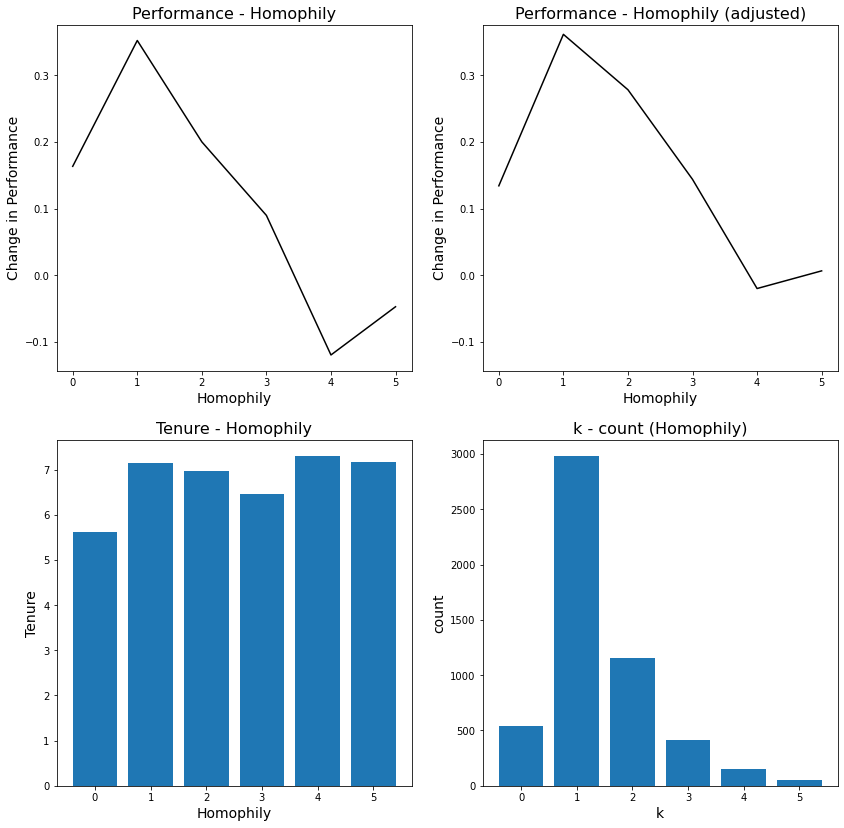

In [45]:
fig = plt.figure(figsize = (14, 14))

ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)

"""Performance-Homophily without age adjustment"""
ax0.plot(table['k'],
         table['med_perf_change'],
         color = 'black')

ax0.set_xlabel('Homophily', size = 14)
ax0.set_ylabel('Change in Performance', size = 14)
ax0.set_title('Performance - Homophily', size = 16)

# get x limit
ylim = ax0.get_ylim()

# ax0.set_xlim((0,xmax))
# ax0.set_ylim((-1,1))


"""Performance-Homophily with age adjustment"""
ax1.plot(table['k'],
         table2['med_perf_change'],
         color = 'black')

ax1.set_xlabel('Homophily', size = 14)
ax1.set_ylabel('Change in Performance', size = 14)
ax1.set_title('Performance - Homophily (adjusted)', size = 16)

# ax1.set_xlim((0,xmax))
ax1.set_ylim(ylim)

"""Tenure-Homophily"""
ax2.bar(x = num_year_df['k'],
        height = num_year_df['average_year_stayed'])

ax2.set_xlabel('Homophily', size = 14)
ax2.set_ylabel('Tenure', size = 14)
ax2.set_title('Tenure - Homophily', size = 16)

# ax2.set_xlim((-1,xmax))

"""k-count (Homophily)"""
ax3.bar(x = table['k'],
        height = table['count'])

ax3.set_xlabel('k', size = 14)
ax3.set_ylabel('count', size = 14)
ax3.set_title('k - count (Homophily)', size = 16)

plt.show()

### Test the existence of homophily

#### Null case simulation
The data is not cleaned but we try to imitate the dataset in the most random manner as possible

In [46]:
# load data
node_edge_df = pd.read_csv(os.path.join(cleaned_data_path, 'node_edge_data.csv'))
perf_eval_df = pd.read_csv(os.path.join(cleaned_data_path, 'perf_eval_table.csv'))

In [47]:
#select only necessary columns
data_simul = node_edge_df[['player_name', 'club_name', 'transfer_movement', 'year']]

In [48]:
data_simul

,player_name,club_name,transfer_movement,year
0,Rene Hofman,Fortuna Sittard,in,1992
1,Peter Schmitz,Fortuna Sittard,in,1992
2,Kenneth Nysaether,Fortuna Sittard,in,1992
3,Arno van Zwam,Fortuna Sittard,in,1992
4,Jerry Taihuttu,Fortuna Sittard,out,1992
...,...,...,...,...
162996,Miguel San Roman,Elche CF,out,2020
162997,Andoni Lopez,Elche CF,out,2020
162998,Dani Escriche,Elche CF,out,2020
162999,Santiago Caseres,Villarreal CF,in,2020


In [49]:
len(data_simul)

163001

In [50]:
# set-up

player_name_list = data_simul['player_name'].unique()
club_name_list = data_simul['club_name'].unique()
year_list = data_simul['year'].unique()

# in-out distribution (just get the `in` and multiply by 2: assume that the data is cleaned)
in_num = sum(data_simul['transfer_movement'] == 'in')

# number of movement distribution
num_move = pd.DataFrame(data_simul.groupby(['player_name', 'year'])['transfer_movement'].agg('count'))
num_move['count'] = 1
num_move = num_move.groupby('transfer_movement')['count'].agg('sum')
num_move = pd.DataFrame(num_move).reset_index()
num_move['transfer_movement'] = [math.ceil(num/2) for num in num_move['transfer_movement']]
num_move = num_move.groupby('transfer_movement')['count'].agg('sum')
num_move = num_move / np.sum(num_move)
num_move = round(num_move * in_num)
num_move = pd.DataFrame(num_move).reset_index()

In [51]:
num_move

,transfer_movement,count
0,1,69090.0
1,2,8007.0
2,3,1249.0
3,4,280.0


In [52]:
# get column names
col_names = data_simul.columns

# simulate data
rows = []
for t, count in zip(num_move['transfer_movement'], num_move['count']):
    for i in tqdm(range(int(count))):
        # get each column value
        player_name = np.repeat(np.random.choice(player_name_list, 1), t)
        club_name = np.random.choice(club_name_list, t, replace = False)
        transfer_movement = np.repeat('in', t)
        year = np.random.choice(year_list, t, replace = False)
        # format data
        row = list(zip(player_name, club_name, transfer_movement, year))
        # add to the list
        rows.extend(row)

# create dataframe
null_case = pd.DataFrame(data = rows, columns = col_names)
null_case.head()

,player_name,club_name,transfer_movement,year
0,Ralf Kohl,Dijon FCO,in,2018
1,Nnamdi Ofoborh,Terek Grozny,in,2003
2,Reinhold Yabo,Blackpool FC,in,1994
3,Marko Livaja,SC Olhanense,in,2002
4,Massimo Fiorentino,Sokol Saratov,in,2010


In [53]:
# sort data
null_case = null_case.sort_values(by = ['player_name', 'year'])

# add column `num_transfer` which represent the number of time a player moved
null_case['count'] = 1
null_case['num_transfer'] = null_case.groupby('player_name')['count'].cumcount() + 1
null_case['max_transfer'] = null_case.groupby('player_name')['num_transfer'].transform(np.max)
null_case.drop(columns = 'count', inplace = True)
null_case.reset_index(drop = True, inplace = True)
null_case

,player_name,club_name,transfer_movement,year,num_transfer,max_transfer
0,Aadil Assana,Atalanta BC,in,1995,1,4
1,Aadil Assana,AS Cannes,in,1998,2,4
2,Aadil Assana,SpVgg Greuther Fürth,in,2014,3,4
3,Aadil Assana,West Bromwich Albion,in,2020,4,4
4,Aaron Amadi-Holloway,Norwich City,in,2018,1,1
...,...,...,...,...,...,...
89966,Zvonko Pamic,AS Cannes,in,2005,2,5
89967,Zvonko Pamic,Plymouth Argyle,in,2007,3,5
89968,Zvonko Pamic,Como Calcio,in,2011,4,5
89969,Zvonko Pamic,Wycombe Wanderers,in,2014,5,5


In [54]:
# add `transfer_movement` == 'out'
to_add = []
for i in tqdm(range(len(null_case))):
    if (null_case.iloc[i]['num_transfer'] > 1) & \
    (null_case.iloc[i]['num_transfer'] < null_case.iloc[i]['max_transfer']):
        # create the 'in' case
        row = list(null_case.iloc[i].replace('out', 'in'))
        # add to `to_add` list
        to_add.append(row)
        
# add data to dataframe
extend = pd.DataFrame(data = to_add, columns = null_case.columns)
null_case = pd.concat([null_case, extend], axis = 0).reset_index(drop = True)
null_case.drop(columns = ['num_transfer', 'max_transfer'], inplace = True)
null_case.sort_values(by = ['player_name', 'year']).reset_index(drop = True, inplace = True)
null_case

,player_name,club_name,transfer_movement,year
0,Aadil Assana,Atalanta BC,in,1995
1,Aadil Assana,AS Cannes,in,1998
2,Aadil Assana,SpVgg Greuther Fürth,in,2014
3,Aadil Assana,West Bromwich Albion,in,2020
4,Aaron Amadi-Holloway,Norwich City,in,2018
...,...,...,...,...
125277,Zvonimir Soldo,ACD Treviso,in,2003
125278,Zvonimir Soldo,Spartak-Alania Vladikavkaz,in,2017
125279,Zvonko Pamic,AS Cannes,in,2005
125280,Zvonko Pamic,Plymouth Argyle,in,2007


#### Null case analysis

In [55]:
# 2 components needed: 'year_list', 'club_list'
year_list = sorted(sorted(null_case['year'].unique()))
club_list = sorted(null_case['club_name'].unique())

In [56]:
# nested dictionary: year: `club_member`
nested_dict = {}
prev_year = None

# loop over year:
for year in tqdm(year_list):
    
    if prev_year in nested_dict.keys():
        
        # retrieve club-player info in the previous year for the second year and so on
        club_member = copy.deepcopy(nested_dict[prev_year])
    
    else:
        # initiate a dictionary of clubs (keys) and their affiliated players (values)
        club_member = {}
    
    # subset data by year
    data = null_case[null_case['year'] == year]
    
    # subset for transfer_movement == 'in', 'out' 
    data_in = data[data['transfer_movement'] == 'in']
    data_out = data[data['transfer_movement'] == 'out']
        
    # loop over club:
    for club in club_list:
        
        # subset data by club 
        temp_data_in = data_in[data_in['club_name'] == club]
        temp_data_out = data_out[data_out['club_name'] == club]
        
        # update all players in that club in the dictionary (`club_member`)
        player_list_in = list(temp_data_in['player_name'])
        player_list_out = list(temp_data_out['player_name'])
        
        if prev_year in nested_dict.keys():
            
            # catch bug
            if club_member[club] is None:
                club_member[club] = []
            
            # adjust for members who move in
            club_member[club].extend(player_list_in)
            # adjust for members who move out
            remove_elem_by_list(club_member[club], player_list_out)
            
        else:
            # update club_member info
            club_member[club] = remove_elem_by_list(player_list_in, player_list_out)
            
    # store `club_member` in `nested_dict`
    nested_dict[year] = club_member
    
    # set previous year
    prev_year = year

In [74]:
perf_eval_df

,club_name,player_name,age,position,club_involved_name,transfer_movement,fee_cleaned,year
0,Ajax Amsterdam,Marc Overmars,19.0,Left Winger,Willem II,in,0.817,1992
1,Ajax Amsterdam,Jari Litmanen,21.0,Attacking Midfield,MYPA,in,0.013,1992
2,Ajax Amsterdam,Aron Winter,25.0,Defensive Midfield,Lazio,out,1.170,1992
3,Sparta Rotterdam,Winston Bogarde,21.0,Centre-Back,Excelsior,in,0.005,1992
4,Willem II Tilburg,Marc Overmars,19.0,Left Winger,Ajax,out,0.817,1992
...,...,...,...,...,...,...,...,...
26589,Celta de Vigo,Pione Sisto,25.0,Left Winger,FC Midtjylland,out,2.250,2020
26590,Elche CF,Raul Guti,23.0,Central Midfield,Real Zaragoza,in,4.500,2020
26591,Elche CF,Tete Morente,23.0,Left Winger,Málaga CF,in,0.450,2020
26592,Elche CF,Juan Cruz,28.0,Left-Back,CA Osasuna,out,2.480,2020


In [77]:
df = null_case

In [57]:
# subset only `transfer_movement` == 'in'; we want to analyze the number of ties a player has
# before entering a team
df = perf_eval_df[perf_eval_df['transfer_movement'] == 'in']
df.reset_index(drop = True, inplace = True)
# clean the table
df.drop_duplicates(inplace = True)

In [78]:
# add column `num_transfer` which represent the number of time a player moved
df['count'] = 1
df['num_transfer'] = df.groupby('player_name')['count'].cumcount() + 1
df['max_transfer'] = df.groupby('player_name')['num_transfer'].transform(np.max)
df.drop(columns = 'count', inplace = True)
df

,player_name,club_name,transfer_movement,year,num_transfer,max_transfer
0,Aadil Assana,Atalanta BC,in,1995,1,6
1,Aadil Assana,AS Cannes,in,1998,2,6
2,Aadil Assana,SpVgg Greuther Fürth,in,2014,3,6
3,Aadil Assana,West Bromwich Albion,in,2020,4,6
4,Aaron Amadi-Holloway,Norwich City,in,2018,1,1
...,...,...,...,...,...,...
125277,Zvonimir Soldo,ACD Treviso,in,2003,5,6
125278,Zvonimir Soldo,Spartak-Alania Vladikavkaz,in,2017,6,6
125279,Zvonko Pamic,AS Cannes,in,2005,6,8
125280,Zvonko Pamic,Plymouth Argyle,in,2007,7,8


In [79]:
# only select the players that have at least two transfers to see the improvement
target_player = list(df[df['num_transfer'] > 1]['player_name'])

df = df[df['player_name'].isin(target_player)]
df.reset_index(drop = True, inplace = True)
df

,player_name,club_name,transfer_movement,year,num_transfer,max_transfer
0,Aadil Assana,Atalanta BC,in,1995,1,6
1,Aadil Assana,AS Cannes,in,1998,2,6
2,Aadil Assana,SpVgg Greuther Fürth,in,2014,3,6
3,Aadil Assana,West Bromwich Albion,in,2020,4,6
4,Aaron Bastiaans,SKA Khabarovsk,in,2003,1,4
...,...,...,...,...,...,...
118379,Zvonimir Soldo,ACD Treviso,in,2003,5,6
118380,Zvonimir Soldo,Spartak-Alania Vladikavkaz,in,2017,6,6
118381,Zvonko Pamic,AS Cannes,in,2005,6,8
118382,Zvonko Pamic,Plymouth Argyle,in,2007,7,8


In [80]:
# get player_list
player_list = list(df['player_name'].unique())
print(f'Number of players: {len(player_list)}')
print(f'Number of clubs: {len(df.club_name.unique())}')

Number of players: 23881
Number of clubs: 401


In [81]:
# initiate a nested dictionary ---> {`was_in` {`aff_clubs` {`year_member`} } }
was_in = {}

# loop over the dataset
for player in tqdm(player_list):
    
    # subset df by player
    temp_df = df[df['player_name'] == player]
    
    # reset_index
    temp_df.reset_index(drop = True, inplace = True)
    
    # initiate inside dictionaries
    aff_clubs = {}
    
    """
    loop over the dataset to get the year and club name 
    this represent that a player stay in a club from year A - year B 
    in this case, we can ignore the last row because no further analysis is needed
    as the next transaction has not occurred yet
    """
    
    for row in range(len(temp_df) - 1):
        
        # initiate inside dictionaries
        year_member = {}
        
        club_name = temp_df.iloc[row]['club_name']
        
        year_list = np.arange(temp_df.iloc[row]['year'], temp_df.iloc[row + 1]['year'])
        
        # get the affiliated player each year from `nested_dict`
        for year in year_list:
            
            aff_players = nested_dict[year][club_name]
            
            # add data to `year_member`
            year_member[year] = aff_players
      
        # add data to aff_club 
        
        # adjust for the case when player moves back to the club he's been before
        if club_name in aff_clubs.keys():
            
                aff_clubs[club_name].update(year_member)
            
        else:
            
            aff_clubs[club_name] = year_member
            
    # add data to was_in
    was_in[player] = aff_clubs

In [82]:
# table we will use
df.sort_values(['player_name', 'num_transfer'], inplace = True)
df.reset_index(drop = True, inplace = True)
df

,player_name,club_name,transfer_movement,year,num_transfer,max_transfer
0,Aadil Assana,Atalanta BC,in,1995,1,6
1,Aadil Assana,AS Cannes,in,1998,2,6
2,Aadil Assana,SpVgg Greuther Fürth,in,2014,3,6
3,Aadil Assana,West Bromwich Albion,in,2020,4,6
4,Aadil Assana,AS Cannes,in,1998,5,6
...,...,...,...,...,...,...
118379,Zvonko Pamic,Como Calcio,in,2011,4,8
118380,Zvonko Pamic,Wycombe Wanderers,in,2014,5,8
118381,Zvonko Pamic,AS Cannes,in,2005,6,8
118382,Zvonko Pamic,Plymouth Argyle,in,2007,7,8


In [83]:
# generate `k` column

# initiate a list
k = []

# loop over the dataset
for i in tqdm(range(len(df))):
    
    # there is nothing to do with the `k` for the first transfer
    if df['num_transfer'][i] == 1:  
        
        k.append(None)
        
    else:  
        # get necessary variables (keys)
        player = df['player_name'][i]
        prev_club = df['club_name'][i-1]
        club = df['club_name'][i]
        prev_year = df['year'][i-1]
        this_year = df['year'][i]
        year_range = np.arange(prev_year, this_year)
        
        # get all the affiliated players
        aff_players = []
        for year in year_range:
            aff_player = was_in[player][prev_club][year]
            aff_players.extend(aff_player)
        
        # get all member in the club player is joining
        in_club_player = nested_dict[this_year][club]
        
        if df['num_transfer'][i] > 2:
            # accumulate affiliated players
            aff_players = set.union(set(prev_set), set(aff_players))
        
        # get `k_val`
        k_val = len(set.intersection(set(aff_players), set(in_club_player)))
        
        # append `k_val` to `k`
        k.append(k_val)
        
        # previous affiliated player set
        prev_set = set(aff_players)

# add `k` column
df['k'] = k

In [84]:
k_count = df[['k']].dropna()
k_count['count'] = 1

In [85]:
k_count = pd.DataFrame(k_count.groupby('k')['count'].agg('count'))

In [86]:
k_count.reset_index(inplace = True)

In [87]:
k_count = k_count[k_count['k'] <= xmax]

#### Visualization

Text(0.5, 1.0, 'k - count (Homophily)')

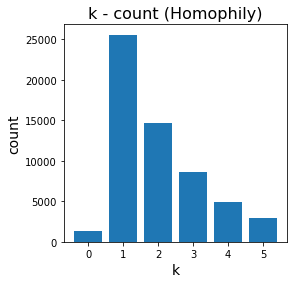

In [88]:
fig = plt.figure(figsize = (4, 4))

ax = fig.add_subplot(1, 1, 1)

ax.bar(x = k_count['k'],
        height = k_count['count'])

ax.set_xlabel('k', size = 14)
ax.set_ylabel('count', size = 14)
ax.set_title('k - count (Homophily)', size = 16)

In [89]:
k_count

,k,count
0,0.0,1311
1,1.0,25553
2,2.0,14603
3,3.0,8620
4,4.0,4971
5,5.0,2962


## Top player similarity analysis

In [69]:
rating_df = pd.read_csv(os.path.join(cleaned_data_path, 'player_rating.csv'))

In [70]:
rating_eval_df = pd.merge(perf_eval_df, rating_df, on = ['player_name', 'year'], how = 'inner')

In [71]:
rating_eval_df = pd.DataFrame(rating_eval_df.groupby(['player_name', 'age', 'position'])['overall_rating'].agg('mean'))
rating_eval_df.reset_index(inplace = True)
top_player_list = rating_eval_df[rating_eval_df['overall_rating'] > 85]['player_name'].unique()
top_player_list

array(['Angel Di Maria', 'Arjen Robben', 'Arturo Vidal',
       'Bastian Schweinsteiger', 'Carlos Tevez', 'Cesc Fabregas',
       'Cristiano Ronaldo', 'David Silva', 'David Villa',
       'Dimitar Berbatov', 'Eden Hazard', 'Edinson Cavani',
       'Ezequiel Lavezzi', 'Fernando Torres', 'Franck Ribery',
       'Gabriel Milito', 'Gareth Bale', 'Gonzalo Higuain', 'Hugo Lloris',
       'James Rodriguez', 'Juan Mata', 'Luca Toni', 'Lucio',
       'Luis Suarez', 'Luka Modric', 'Manuel Neuer', 'Mario Gomez',
       'Mats Hummels', 'Miroslav Klose', 'Paul Pogba',
       'Rafael van der Vaart', 'Robin van Persie', 'Ronaldinho',
       'Roy Makaay', 'Samir Nasri', "Samuel Eto'o", 'Sergio Aguero',
       'Thiago Silva', 'Thierry Henry', 'Wesley Sneijder', 'Ze Roberto',
       'Zlatan Ibrahimovic'], dtype=object)

In [72]:
top_eval = df[df['player_name'].isin(top_player_list)]

In [73]:
top_eval[top_eval['num_transfer'] >= 3][['club_name', 'player_name', 'age', 'year', 'club_involved_name', 'adjusted_fee','k', 'perf_change_adjusted']].sort_values(by = 'year')

KeyError: "['adjusted_fee', 'perf_change_adjusted'] not in index"

In [ ]:
pd.DataFrame(top_eval.groupby('club_name')['transfer_movement'].agg('count'))\
.sort_values(by = 'transfer_movement', ascending = False)

In [ ]:
player_in_madrid = top_eval[top_eval['club_name'] == 'Real Madrid']['player_name'].unique()

In [ ]:
top_eval[top_eval['player_name'].isin(player_in_madrid)]